In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [3]:
human_lombardo = pd.read_csv("../data/human_smiles_r_v3.csv")
human_lombardo = human_lombardo[human_lombardo["smiles_r"]!="Cannot_do"].reset_index(drop=True)

In [4]:
human_lombardo=  human_lombardo[["smiles_r","human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]]

for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_mrt", "human_thalf" ]:
    print("Transformed endpoint to log base 10")
    human_lombardo[endpoint] = np.log10(human_lombardo[endpoint])
human_lombardo

Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10
Transformed endpoint to log base 10


,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426
...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835


In [5]:
human_lombardo = human_lombardo.groupby('smiles_r').median().reset_index()
human_lombardo

,smiles_r,human_VDss_L_kg,human_CL_mL_min_kg,human_fup,human_mrt,human_thalf
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...,0.006466,0.638489,0.33,0.568202,1.176091
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.079181,0.949390,NaN,1.348305,1.705008
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...,-0.275724,-0.537602,0.01,1.482588,1.894870
3,C#CC[NH+](C)C(C)Cc1ccccc1,0.278754,1.301030,0.13,0.204120,0.113943
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,0.041393,0.204120,NaN,1.068186,1.037426
...,...,...,...,...,...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2,0.556303,0.903090,NaN,1.021189,0.913814
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1,0.838849,0.707570,0.35,1.361728,1.204120
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1,0.612784,0.934498,0.50,0.892095,0.863323
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1,0.591065,1.293804,NaN,0.537819,0.359835


In [6]:
human_smiles_r = human_lombardo[["smiles_r"]]
human_smiles_r

,smiles_r
0,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)NC(CCC(...
1,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
2,C#CCN(Cc1cc2c(=O)nc(C)[n-]c2cc1C)c1ccc(C(=O)NC...
3,C#CC[NH+](C)C(C)Cc1ccccc1
4,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...
...,...
1278,c1cc2c(c(N3CC[NH2+]CC3)c1)OCCO2
1279,c1ccc(C2([NH+]3CCCCC3)CCCCC2)cc1
1280,c1ccc(C2(c3ccccc3)CC2C2=[NH+]CCN2)cc1
1281,c1ccc(CN(CC2=[NH+]CCN2)c2ccccc2)cc1


In [7]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "human_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "human_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "human_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "human_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

human_VDss_L_kg
0
Mean Predictor
250
2-fold :  40.0
3-fold :  48.4
5-fold :  67.2
gmfe :  3.336014289012137
mfe :  1.6662292004780557
bias :  0.11772918336099902
rmse  0.656860876730667
r2  0.0


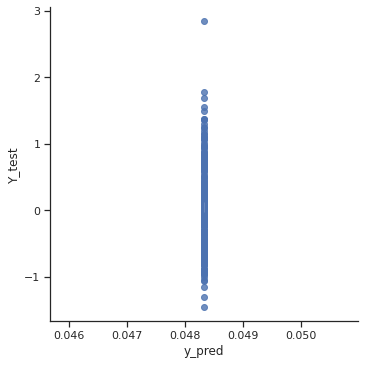

1
Mean Predictor
250
2-fold :  36.0
3-fold :  52.400000000000006
5-fold :  74.8
gmfe :  3.1764368136323564
mfe :  1.560618640909063
bias :  0.0641623550744233
rmse  0.6110180862856072
r2  0.0


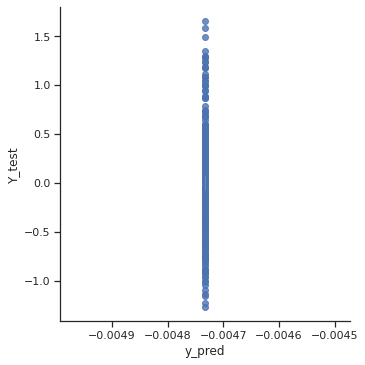

2
Mean Predictor
250
2-fold :  34.0
3-fold :  49.6
5-fold :  68.8
gmfe :  3.3871137925616273
mfe :  1.6558432544707626
bias :  0.1467520799845542
rmse  0.6590721518149776
r2  0.0


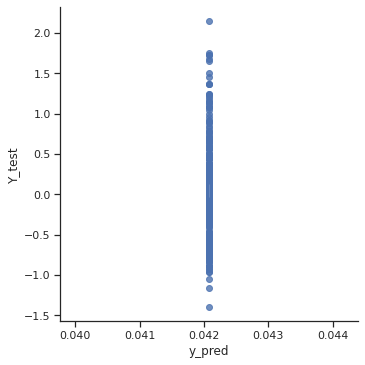

3
Mean Predictor
250
2-fold :  36.4
3-fold :  52.0
5-fold :  67.60000000000001
gmfe :  3.3150487782892197
mfe :  1.5871300737160794
bias :  0.07540963892783226
rmse  0.647148500601669
r2  0.0


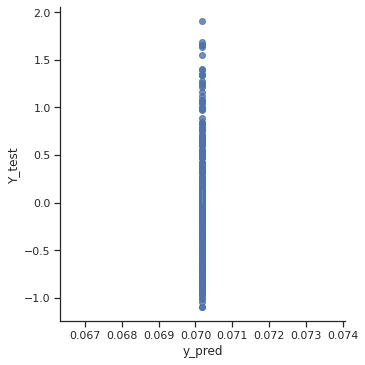

4
Mean Predictor
249
2-fold :  35.7429718875502
3-fold :  50.602409638554214
5-fold :  71.4859437751004
gmfe :  3.241826904729222
mfe :  1.5954113370585012
bias :  0.11737758395892994
rmse  0.6211477535931201
r2  0.0


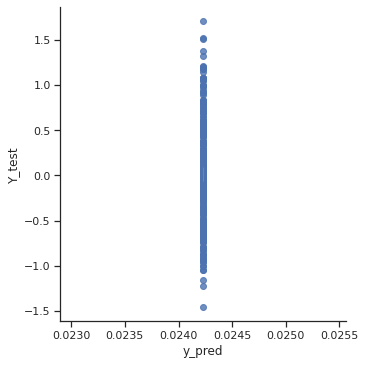

0
Mean Predictor
250
2-fold :  42.0
3-fold :  54.0
5-fold :  74.0
gmfe :  3.0322570334966046
mfe :  1.5055510689808818
bias :  0.10486033997939459
rmse  0.6043850004048338
r2  0.0


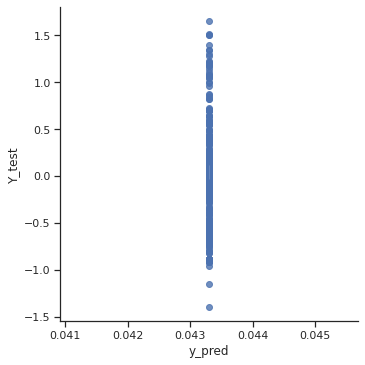

1
Mean Predictor
250
2-fold :  34.4
3-fold :  48.8
5-fold :  63.2
gmfe :  3.5575279483211792
mfe :  1.6402029542518912
bias :  0.04405114510509933
rmse  0.6781521820595983
r2  0.0


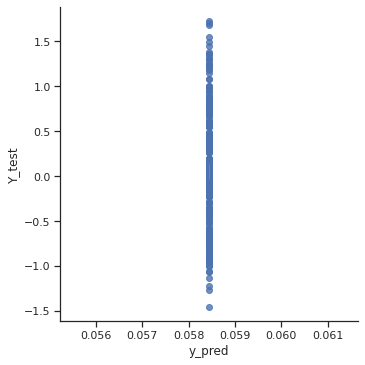

2
Mean Predictor
250
2-fold :  33.2
3-fold :  49.2
5-fold :  71.2
gmfe :  3.29303191564726
mfe :  1.6266065238299665
bias :  0.07650978672701303
rmse  0.6266904006587001
r2  0.0


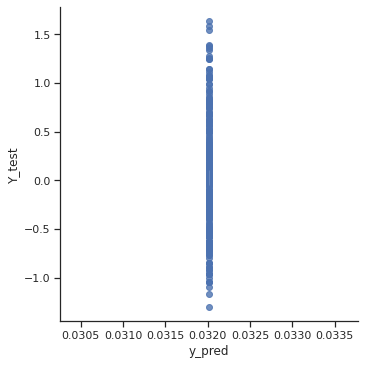

3
Mean Predictor
250
2-fold :  40.0
3-fold :  53.2
5-fold :  70.0
gmfe :  3.1945370620937785
mfe :  1.5516035096821972
bias :  0.06573802435189358
rmse  0.6369113049716035
r2  0.0


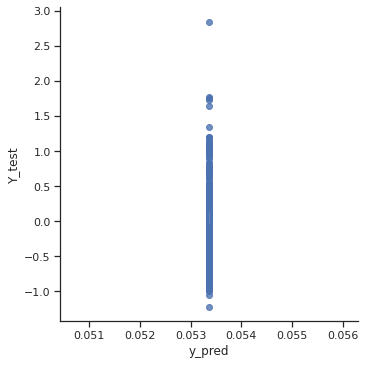

4
Mean Predictor
249
2-fold :  32.1285140562249
3-fold :  48.19277108433735
5-fold :  77.91164658634538
gmfe :  3.3758406398451424
mfe :  1.6691272915167898
bias :  0.14366918902325887
rmse  0.648697738401838
r2  0.0


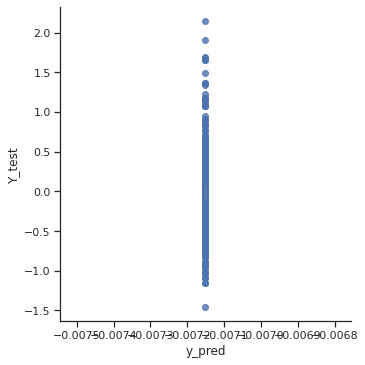

0
Mean Predictor
250
2-fold :  34.4
3-fold :  47.199999999999996
5-fold :  70.0
gmfe :  3.3591367911710006
mfe :  1.6867550224872567
bias :  0.12648943232873067
rmse  0.6397538814798531
r2  0.0


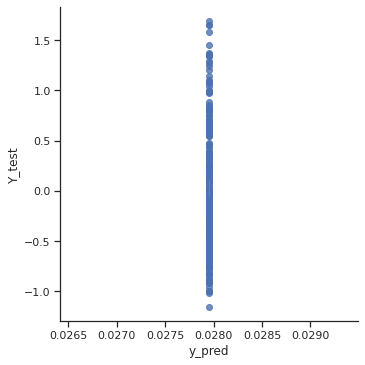

1
Mean Predictor
250
2-fold :  36.0
3-fold :  50.0
5-fold :  68.4
gmfe :  3.4553492478851373
mfe :  1.6093778250072315
bias :  0.028944309385810163
rmse  0.6731654527908617
r2  0.0


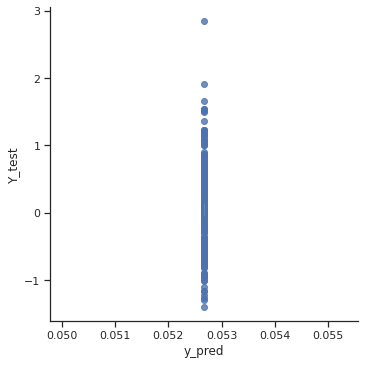

2
Mean Predictor
250
2-fold :  35.199999999999996
3-fold :  52.400000000000006
5-fold :  72.39999999999999
gmfe :  3.2980316933378373
mfe :  1.5222810319331401
bias :  0.12328878847799651
rmse  0.6463959802264474
r2  0.0


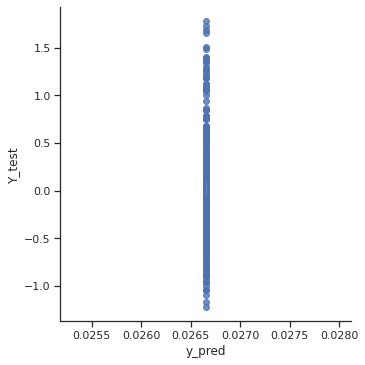

3
Mean Predictor
250
2-fold :  39.2
3-fold :  51.6
5-fold :  70.39999999999999
gmfe :  3.107069675388043
mfe :  1.5787543121020897
bias :  0.0732988966643765
rmse  0.6035261777258786
r2  0.0


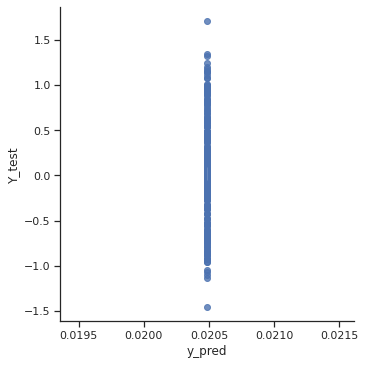

4
Mean Predictor
249
2-fold :  36.94779116465863
3-fold :  53.01204819277109
5-fold :  73.09236947791165
gmfe :  3.2262321564457164
mfe :  1.551010783837217
bias :  0.02837864101039278
rmse  0.6337038286003355
r2  0.0


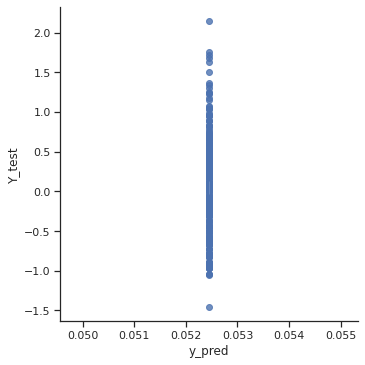

0
Mean Predictor
250
2-fold :  38.4
3-fold :  54.400000000000006
5-fold :  70.39999999999999
gmfe :  3.179669987213015
mfe :  1.5370081014611716
bias :  0.02652443407107974
rmse  0.6433084922670662
r2  0.0


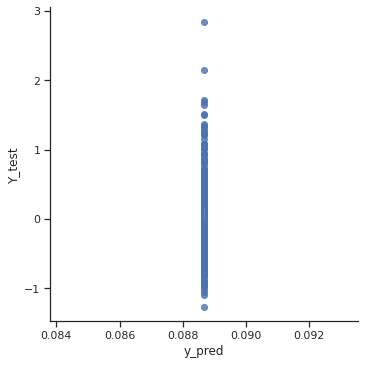

1
Mean Predictor
250
2-fold :  38.4
3-fold :  55.2
5-fold :  75.6
gmfe :  3.024580223946079
mfe :  1.5187275629996149
bias :  0.09014026585846191
rmse  0.5940389354696932
r2  0.0


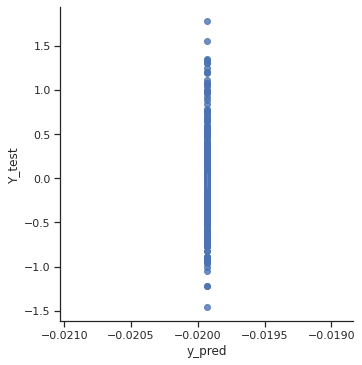

2
Mean Predictor
250
2-fold :  28.000000000000004
3-fold :  44.0
5-fold :  66.8
gmfe :  3.720315080687703
mfe :  1.7355618102890726
bias :  0.18076999918600767
rmse  0.6757749721296101
r2  0.0


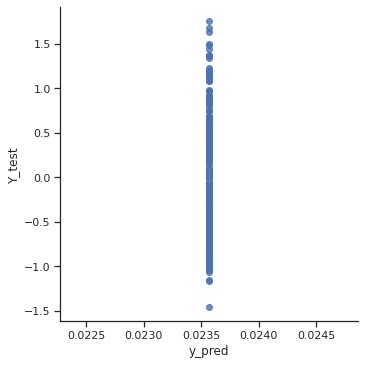

3
Mean Predictor
250
2-fold :  41.199999999999996
3-fold :  53.2
5-fold :  70.0
gmfe :  3.1362837768366445
mfe :  1.5267689149976846
bias :  0.02776375794911823
rmse  0.6277745895003609
r2  0.0


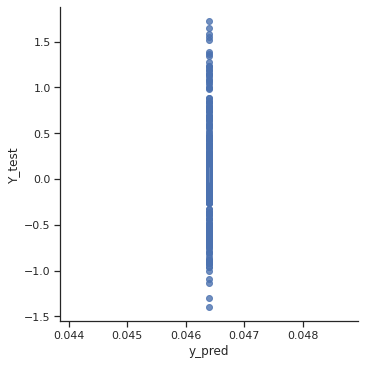

4
Mean Predictor
249
2-fold :  35.7429718875502
3-fold :  49.39759036144578
5-fold :  67.8714859437751
gmfe :  3.3896895663118003
mfe :  1.6530257120481482
bias :  0.16017221061415343
rmse  0.6507074584903182
r2  0.0


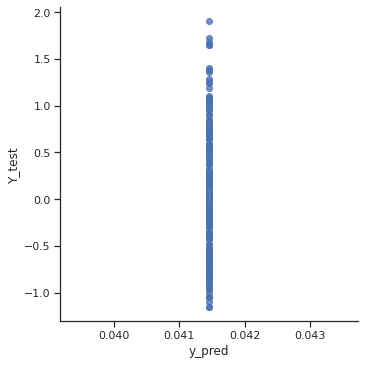

0
Mean Predictor
250
2-fold :  37.2
3-fold :  52.0
5-fold :  70.0
gmfe :  3.2432873452893527
mfe :  1.5475026295992458
bias :  0.12677737380176224
rmse  0.6247644673740745
r2  0.0


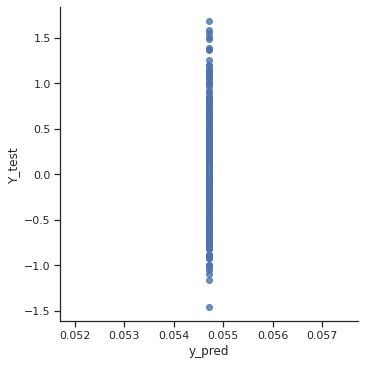

1
Mean Predictor
250
2-fold :  34.8
3-fold :  48.0
5-fold :  69.6
gmfe :  3.4061109024239293
mfe :  1.6756323056483697
bias :  0.10731285840508265
rmse  0.6507610928080518
r2  0.0


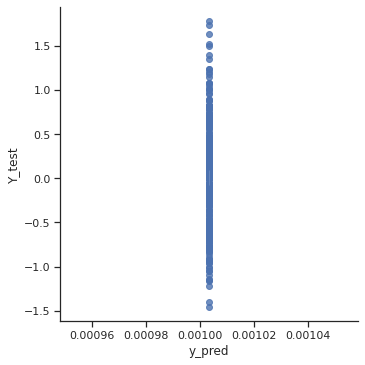

2
Mean Predictor
250
2-fold :  36.4
3-fold :  51.6
5-fold :  70.0
gmfe :  3.2739065068593853
mfe :  1.6051117433811017
bias :  0.12999382730733355
rmse  0.6369039046710107
r2  0.0


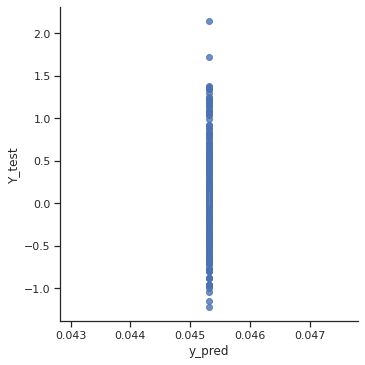

3
Mean Predictor
250
2-fold :  35.6
3-fold :  51.2
5-fold :  69.6
gmfe :  3.317064605026576
mfe :  1.5823569798712276
bias :  0.047092512564439915
rmse  0.6512660507078494
r2  0.0


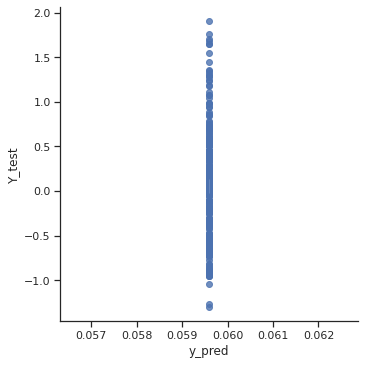

4
Mean Predictor
249
2-fold :  38.152610441767074
3-fold :  52.610441767068274
5-fold :  73.09236947791165
gmfe :  3.1967197978436834
mfe :  1.5689009349662866
bias :  0.10579529394824072
rmse  0.6331825795039364
r2  0.0


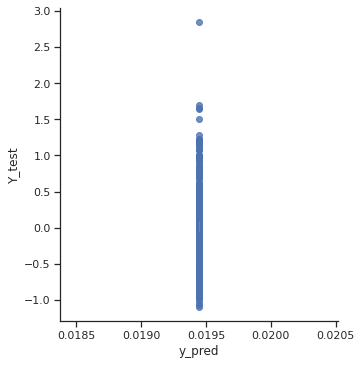

human_CL_mL_min_kg
0
Mean Predictor
257
2-fold :  34.24124513618677
3-fold :  57.97665369649806
5-fold :  78.98832684824903
gmfe :  3.277259774393109
mfe :  1.5041696915296092
bias :  -1.0039898078042029
rmse  0.6753204416751428
r2  0.0


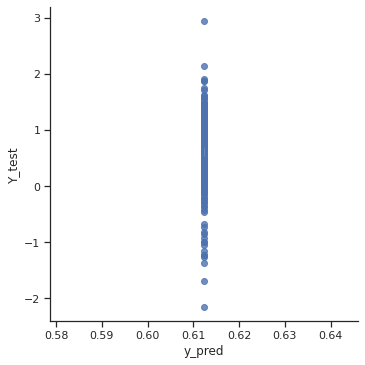

1
Mean Predictor
256
2-fold :  33.984375
3-fold :  58.984375
5-fold :  77.34375
gmfe :  3.1408095042236828
mfe :  1.5158172261680045
bias :  -0.28853182829398394
rmse  0.6373713940907035
r2  0.0


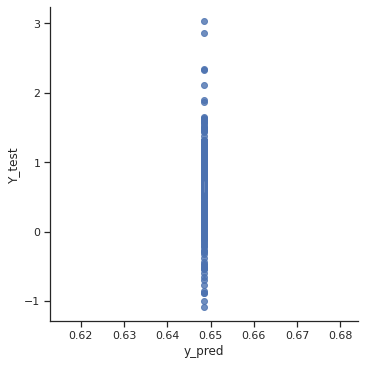

2
Mean Predictor
256
2-fold :  37.890625
3-fold :  64.84375
5-fold :  80.078125
gmfe :  2.8798741469403435
mfe :  1.436526810762135
bias :  -0.2972802022782277
rmse  0.6007852434891864
r2  0.0


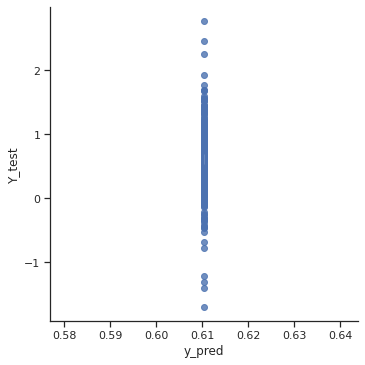

3
Mean Predictor
256
2-fold :  36.328125
3-fold :  58.984375
5-fold :  76.5625
gmfe :  3.243232289381246
mfe :  1.5135706912703404
bias :  -1.5993396296811215
rmse  0.6577618783000638
r2  0.0


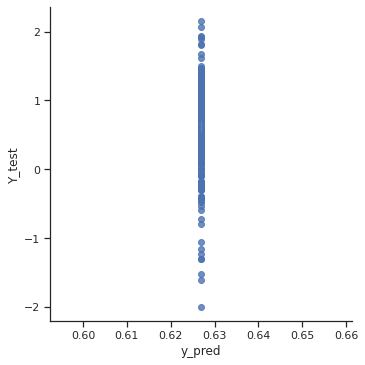

4
Mean Predictor
256
2-fold :  34.765625
3-fold :  57.421875
5-fold :  76.953125
gmfe :  3.238416284391776
mfe :  1.4887547148558855
bias :  -0.23682205509597143
rmse  0.6690538664926176
r2  0.0


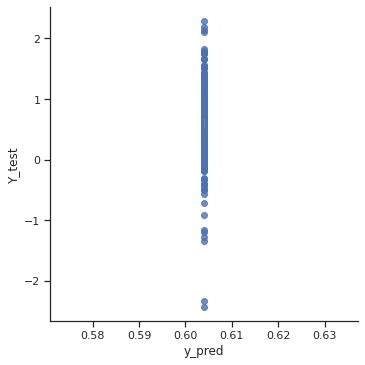

0
Mean Predictor
257
2-fold :  36.57587548638132
3-fold :  54.474708171206224
5-fold :  73.15175097276264
gmfe :  3.4651521150964255
mfe :  1.5260648052783523
bias :  -0.5200626018896966
rmse  0.7120060436669742
r2  0.0


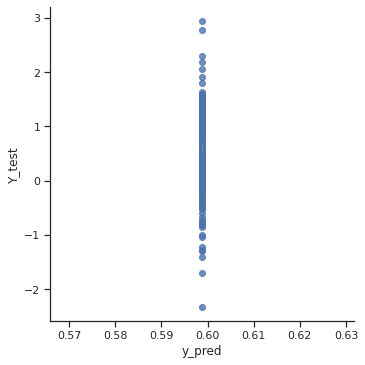

1
Mean Predictor
256
2-fold :  32.03125
3-fold :  56.25
5-fold :  74.609375
gmfe :  3.4828347655631045
mfe :  1.5440962290136708
bias :  -0.5469131763655706
rmse  0.707428575713762
r2  0.0


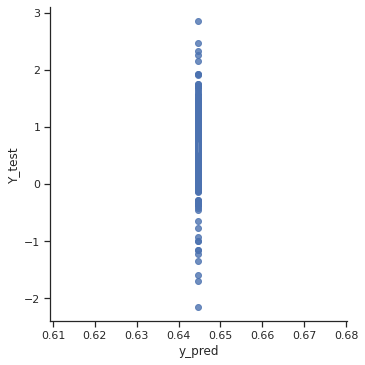

2
Mean Predictor
256
2-fold :  35.9375
3-fold :  60.15625
5-fold :  79.296875
gmfe :  2.9536322766918763
mfe :  1.475928327806439
bias :  -0.05955523024139264
rmse  0.6011268748735151
r2  0.0


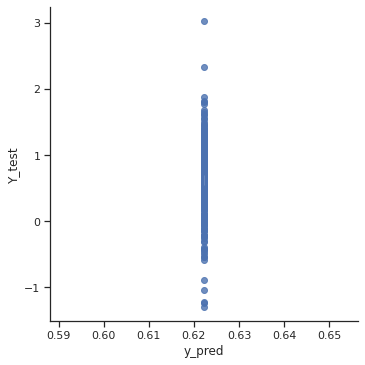

3
Mean Predictor
256
2-fold :  37.890625
3-fold :  64.0625
5-fold :  80.46875
gmfe :  2.9342609461681493
mfe :  1.457414292901571
bias :  -1.0034634968068765
rmse  0.6036080577517091
r2  0.0


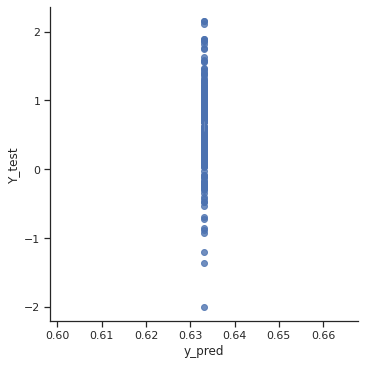

4
Mean Predictor
256
2-fold :  34.375
3-fold :  61.328125
5-fold :  81.640625
gmfe :  2.980403700544011
mfe :  1.4835492250430162
bias :  -1.1328214162630825
rmse  0.6082533758323372
r2  0.0


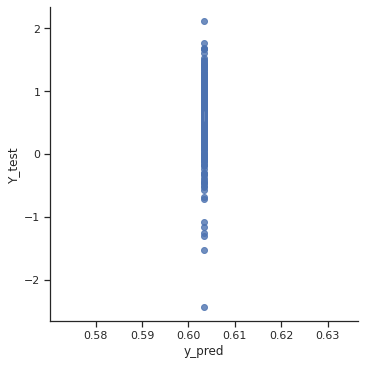

0
Mean Predictor
257
2-fold :  36.18677042801556
3-fold :  61.08949416342413
5-fold :  76.65369649805449
gmfe :  3.051727909922441
mfe :  1.476924616842516
bias :  -0.7184244622337737
rmse  0.6358068140343638
r2  0.0


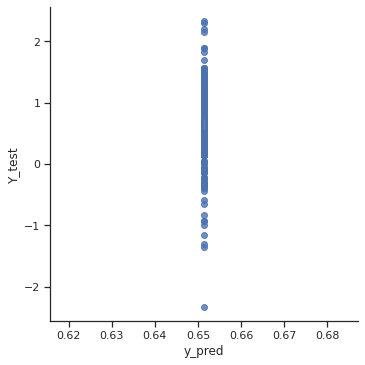

1
Mean Predictor
256
2-fold :  39.453125
3-fold :  59.375
5-fold :  78.90625
gmfe :  3.0095050765344062
mfe :  1.4883373698476046
bias :  -1.0764517929850763
rmse  0.6279884053357768
r2  0.0


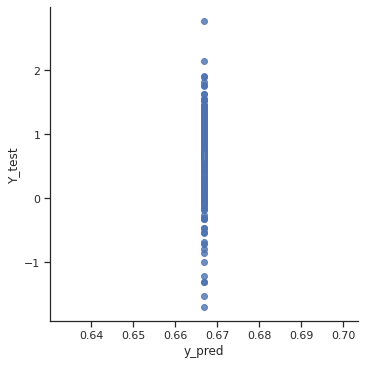

2
Mean Predictor
256
2-fold :  35.15625
3-fold :  58.59375
5-fold :  76.171875
gmfe :  3.3089060972000035
mfe :  1.5345218941686296
bias :  -0.2466936022201076
rmse  0.6725392738209992
r2  0.0


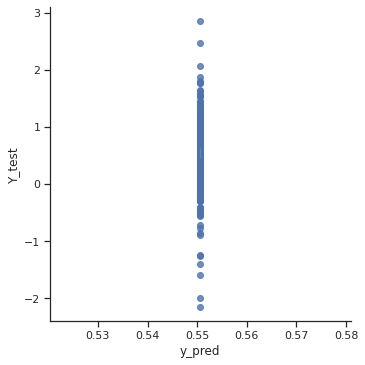

3
Mean Predictor
256
2-fold :  38.671875
3-fold :  60.546875
5-fold :  78.515625
gmfe :  3.182144709895063
mfe :  1.4574943911728204
bias :  -0.32267842257182977
rmse  0.6765834889371226
r2  0.0


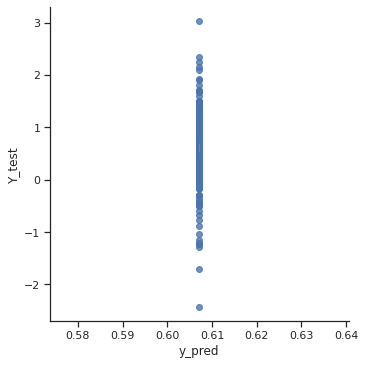

4
Mean Predictor
256
2-fold :  37.109375
3-fold :  56.640625
5-fold :  75.78125
gmfe :  3.151876055935681
mfe :  1.5198875490771206
bias :  -0.5483303013165961
rmse  0.6229780703590954
r2  0.0


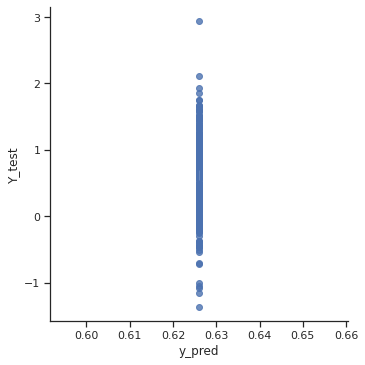

0
Mean Predictor
257
2-fold :  38.91050583657588
3-fold :  61.08949416342413
5-fold :  78.98832684824903
gmfe :  2.8990121515429776
mfe :  1.4732453226678495
bias :  -0.4631689623748114
rmse  0.5771279158324192
r2  0.0


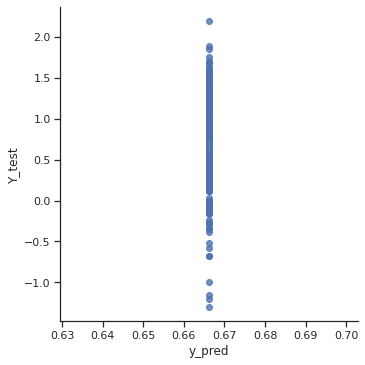

1
Mean Predictor
256
2-fold :  33.984375
3-fold :  58.984375
5-fold :  77.34375
gmfe :  3.1054801913306918
mfe :  1.481226229936338
bias :  -0.9435210540314811
rmse  0.610775025026019
r2  0.0


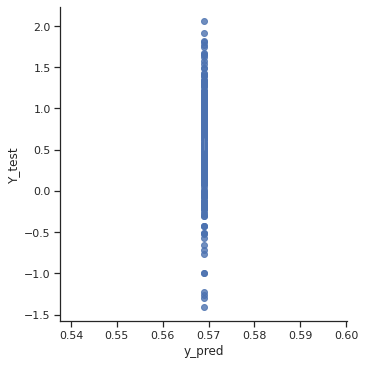

2
Mean Predictor
256
2-fold :  36.71875
3-fold :  59.375
5-fold :  79.296875
gmfe :  3.1600533887267805
mfe :  1.4692632597728472
bias :  -0.19944886868510014
rmse  0.6668375630307567
r2  0.0


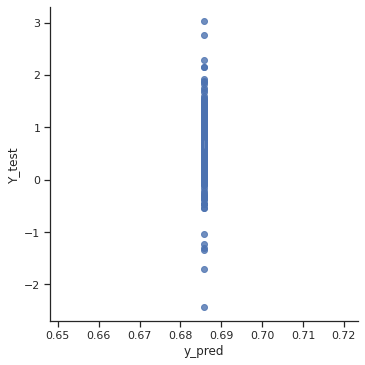

3
Mean Predictor
256
2-fold :  36.71875
3-fold :  61.71875
5-fold :  80.078125
gmfe :  3.0563300808188214
mfe :  1.4504179675747253
bias :  -0.15903609058994395
rmse  0.6400952892806553
r2  0.0


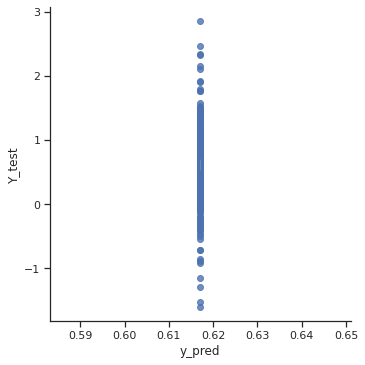

4
Mean Predictor
256
2-fold :  33.203125
3-fold :  51.171875
5-fold :  75.0
gmfe :  3.570752646824186
mfe :  1.5736056564827106
bias :  -1.086077796419266
rmse  0.7297446337294046
r2  0.0


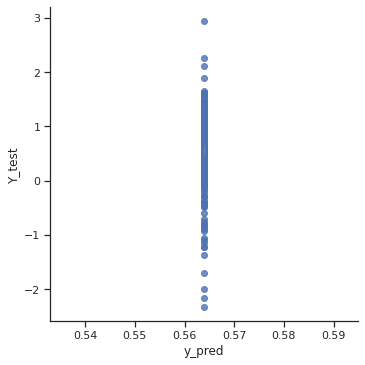

0
Mean Predictor
257
2-fold :  42.023346303501945
3-fold :  63.42412451361867
5-fold :  77.431906614786
gmfe :  2.9957681601225494
mfe :  1.4517589020355226
bias :  -0.6375216523892986
rmse  0.6345909661059972
r2  0.0


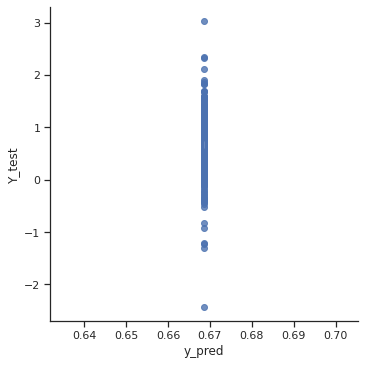

1
Mean Predictor
256
2-fold :  32.8125
3-fold :  53.125
5-fold :  73.046875
gmfe :  3.5532454740443353
mfe :  1.5912355121778623
bias :  -0.8802006742761974
rmse  0.7161774590140334
r2  0.0


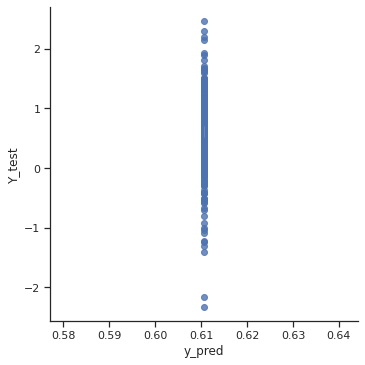

2
Mean Predictor
256
2-fold :  33.203125
3-fold :  59.375
5-fold :  76.5625
gmfe :  3.2654349710652473
mfe :  1.4981441598460528
bias :  -0.09531790677836671
rmse  0.6628427033813409
r2  0.0


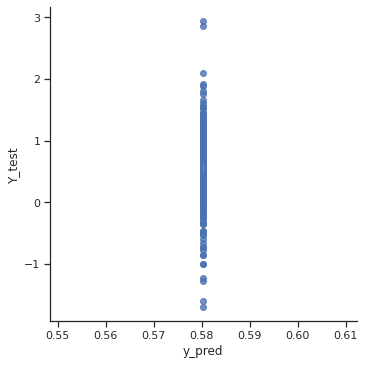

3
Mean Predictor
256
2-fold :  36.71875
3-fold :  59.375
5-fold :  77.734375
gmfe :  3.1512397282242595
mfe :  1.4722222546317063
bias :  -0.7689398706292319
rmse  0.6459596651387326
r2  0.0


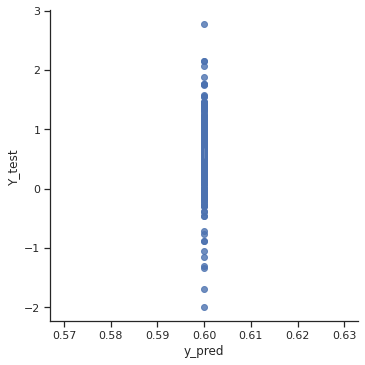

4
Mean Predictor
256
2-fold :  39.453125
3-fold :  61.328125
5-fold :  83.59375
gmfe :  2.8149995648125783
mfe :  1.441931825978542
bias :  -0.4652530531515291
rmse  0.5725574457624044
r2  0.0


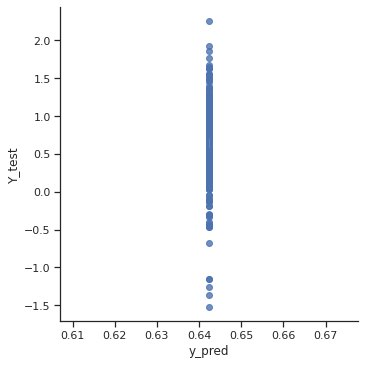

human_fup
0
Mean Predictor
176
2-fold :  30.113636363636363
3-fold :  59.65909090909091
5-fold :  63.63636363636363
gmfe :  5.235767889398094
mfe :  1.5719924610957
bias :  0.15613465909090907
rmse  0.35127177333501935
r2  0.0


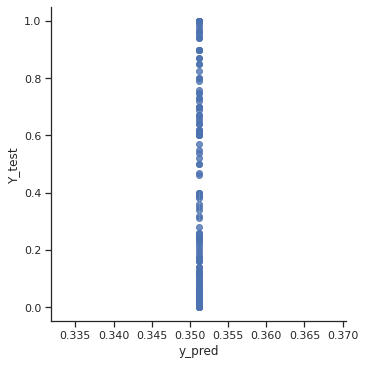

1
Mean Predictor
176
2-fold :  31.25
3-fold :  54.54545454545454
5-fold :  71.02272727272727
gmfe :  4.372158850325073
mfe :  1.5557287805130875
bias :  0.13765454545454547
rmse  0.31831616426735904
r2  0.0


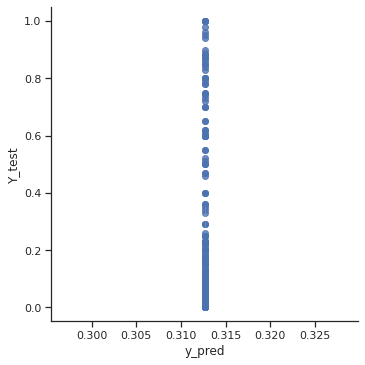

2
Mean Predictor
176
2-fold :  33.52272727272727
3-fold :  61.93181818181818
5-fold :  75.56818181818183
gmfe :  3.8725487878014007
mfe :  1.4624696573459859
bias :  0.08960916413636363
rmse  0.34662617751624875
r2  0.0


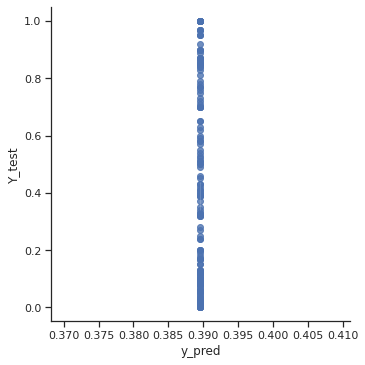

3
Mean Predictor
176
2-fold :  25.0
3-fold :  57.95454545454546
5-fold :  68.18181818181817
gmfe :  4.446756641308975
mfe :  1.5482172710899234
bias :  0.15905454545454545
rmse  0.3463039288193284
r2  0.0


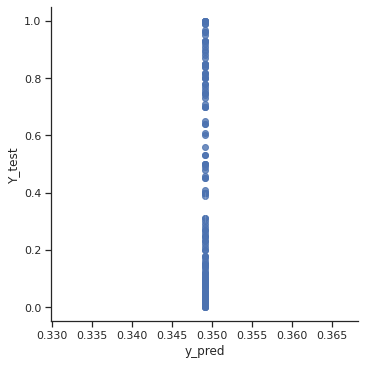

4
Mean Predictor
175
2-fold :  33.714285714285715
3-fold :  60.57142857142858
5-fold :  65.14285714285715
gmfe :  4.431872010543391
mfe :  1.5286694276661041
bias :  0.1054148893657143
rmse  0.33588598163515077
r2  0.0


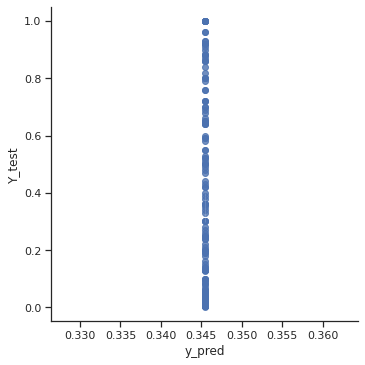

0
Mean Predictor
176
2-fold :  25.0
3-fold :  58.52272727272727
5-fold :  69.31818181818183
gmfe :  4.424365516290714
mfe :  1.544352759132956
bias :  0.17138228421022725
rmse  0.3388154377522382
r2  0.0


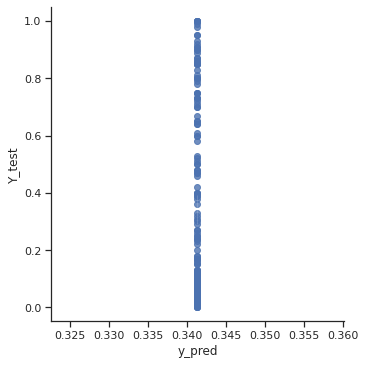

1
Mean Predictor
176
2-fold :  34.090909090909086
3-fold :  63.63636363636363
5-fold :  71.5909090909091
gmfe :  4.246441158131802
mfe :  1.491123802676924
bias :  0.1307443181818182
rmse  0.32121802294262924
r2  0.0


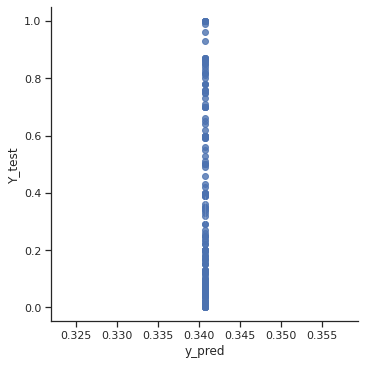

2
Mean Predictor
176
2-fold :  25.568181818181817
3-fold :  57.38636363636363
5-fold :  67.61363636363636
gmfe :  5.201204189993934
mfe :  1.535124246676057
bias :  0.18272513419318187
rmse  0.3692852855447766
r2  0.0


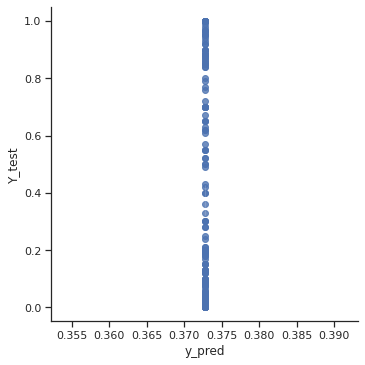

3
Mean Predictor
176
2-fold :  27.84090909090909
3-fold :  57.38636363636363
5-fold :  68.75
gmfe :  4.694339320628181
mfe :  1.538061264258707
bias :  0.16047961868181815
rmse  0.35615896942418873
r2  0.0


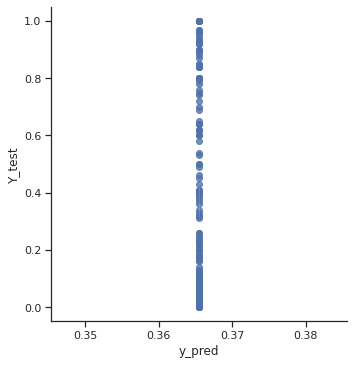

4
Mean Predictor
175
2-fold :  33.14285714285714
3-fold :  60.0
5-fold :  66.85714285714286
gmfe :  3.8895444983849785
mfe :  1.4938098398181983
bias :  0.09743428571428572
rmse  0.31288072573869985
r2  0.0


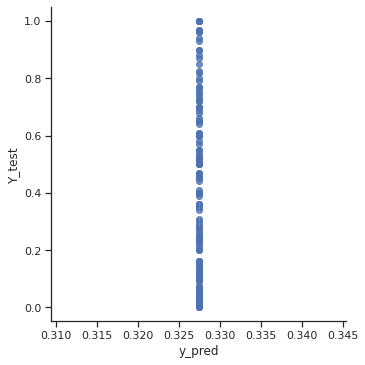

0
Mean Predictor
176
2-fold :  30.681818181818183
3-fold :  60.79545454545454
5-fold :  69.88636363636364
gmfe :  4.21703511324001
mfe :  1.5129322345526701
bias :  0.1369391023920455
rmse  0.3491802832257754
r2  0.0


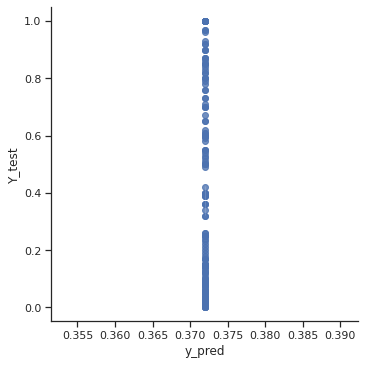

1
Mean Predictor
176
2-fold :  31.25
3-fold :  57.95454545454546
5-fold :  67.61363636363636
gmfe :  4.460530708869457
mfe :  1.5294714795425808
bias :  0.14299715909090904
rmse  0.33057118326895696
r2  0.0


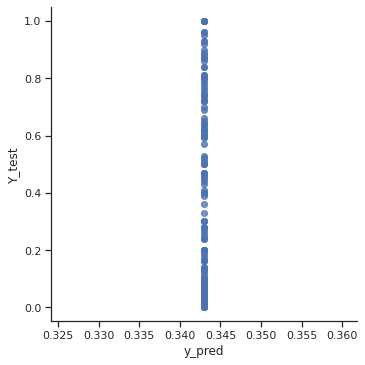

2
Mean Predictor
176
2-fold :  34.090909090909086
3-fold :  60.22727272727273
5-fold :  68.75
gmfe :  4.557594425543842
mfe :  1.5313236662252414
bias :  0.11734715909090908
rmse  0.3389882137815979
r2  0.0


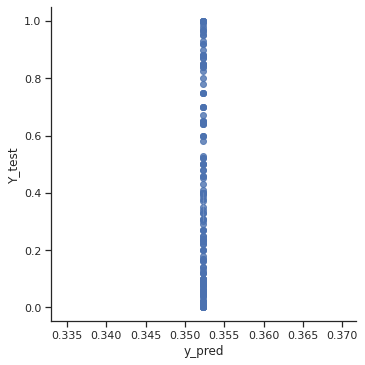

3
Mean Predictor
176
2-fold :  28.97727272727273
3-fold :  61.93181818181818
5-fold :  68.75
gmfe :  4.739506782521686
mfe :  1.5253341634586295
bias :  0.15934375
rmse  0.35224420161952114
r2  0.0


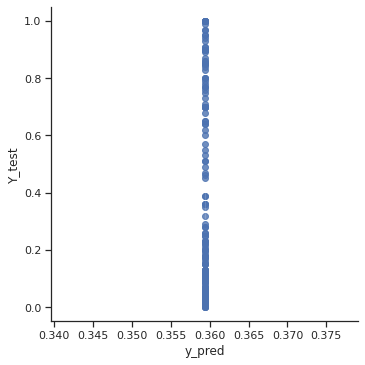

4
Mean Predictor
175
2-fold :  26.857142857142858
3-fold :  57.14285714285714
5-fold :  68.0
gmfe :  4.356020874247565
mfe :  1.5532666822562031
bias :  0.15110249431999997
rmse  0.3300461233772925
r2  0.0


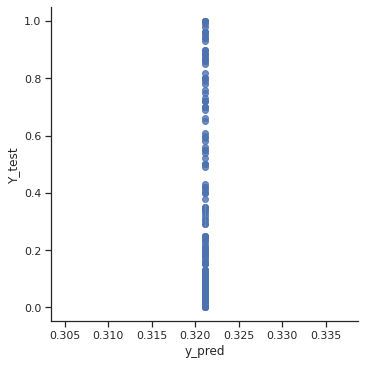

0
Mean Predictor
176
2-fold :  30.113636363636363
3-fold :  48.29545454545455
5-fold :  65.9090909090909
gmfe :  4.530110128267731
mfe :  1.6211819709210935
bias :  0.1313784823181818
rmse  0.3058887929573076
r2  0.0


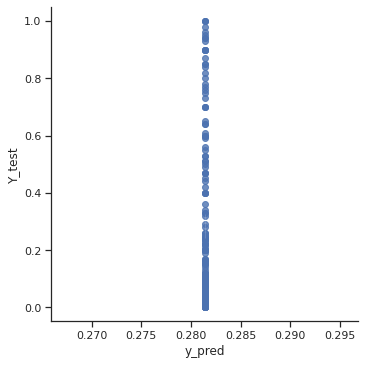

1
Mean Predictor
176
2-fold :  34.090909090909086
3-fold :  60.22727272727273
5-fold :  69.88636363636364
gmfe :  4.239633908347603
mfe :  1.479161046582531
bias :  0.11984886363636366
rmse  0.34017791150511434
r2  0.0


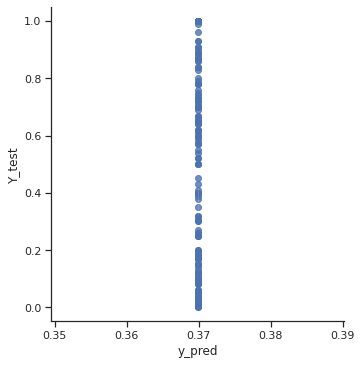

2
Mean Predictor
176
2-fold :  32.95454545454545
3-fold :  59.65909090909091
5-fold :  66.47727272727273
gmfe :  4.497558248287035
mfe :  1.4787860470789693
bias :  0.09295013419318188
rmse  0.3556074193923498
r2  0.0


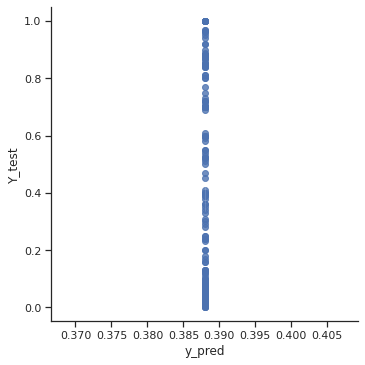

3
Mean Predictor
176
2-fold :  30.113636363636363
3-fold :  61.93181818181818
5-fold :  70.45454545454545
gmfe :  4.214890078699518
mfe :  1.547530350983223
bias :  0.13890852272727272
rmse  0.3372303420817067
r2  0.0


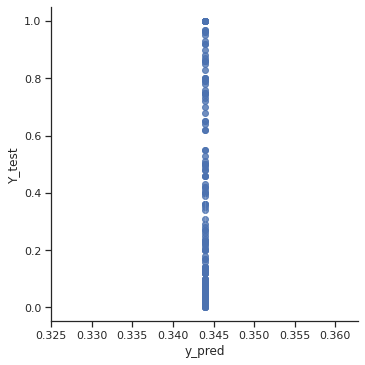

4
Mean Predictor
175
2-fold :  26.857142857142858
3-fold :  61.71428571428571
5-fold :  70.28571428571428
gmfe :  4.654138676341526
mfe :  1.5221233994709014
bias :  0.16489246869142854
rmse  0.3526958048399761
r2  0.0


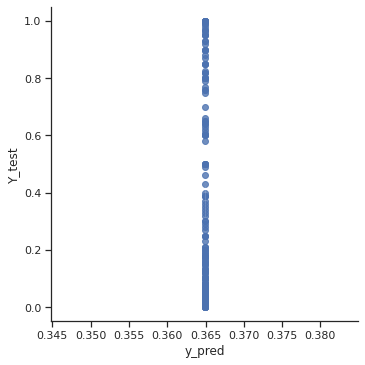

0
Mean Predictor
176
2-fold :  25.568181818181817
3-fold :  59.09090909090909
5-fold :  68.18181818181817
gmfe :  4.858219848677852
mfe :  1.5624404027556889
bias :  0.16857556818181818
rmse  0.34976407393334424
r2  0.0


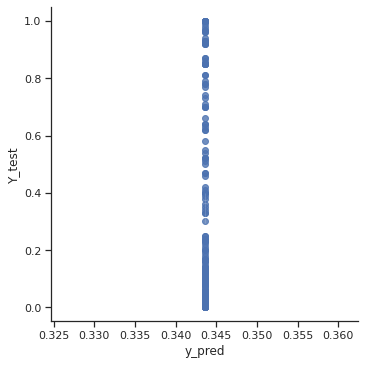

1
Mean Predictor
176
2-fold :  29.545454545454547
3-fold :  61.93181818181818
5-fold :  72.1590909090909
gmfe :  4.277677519579528
mfe :  1.5270409130238685
bias :  0.14456818181818182
rmse  0.33193542962773465
r2  0.0


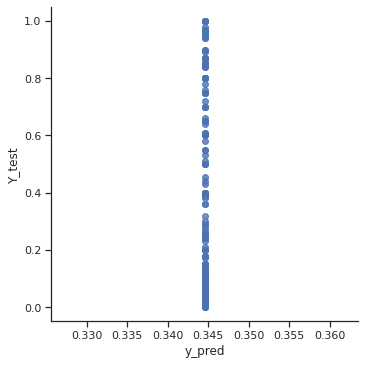

2
Mean Predictor
176
2-fold :  28.97727272727273
3-fold :  59.65909090909091
5-fold :  67.04545454545455
gmfe :  4.480028261308923
mfe :  1.5436719175131206
bias :  0.1543467251022727
rmse  0.3461734011857452
r2  0.0


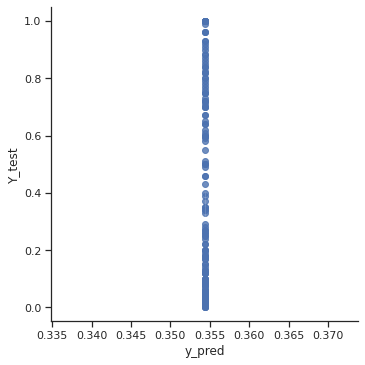

3
Mean Predictor
176
2-fold :  37.5
3-fold :  63.63636363636363
5-fold :  70.45454545454545
gmfe :  4.228644118690354
mfe :  1.4795363412505633
bias :  0.10707045454545455
rmse  0.32861371134838097
r2  0.0


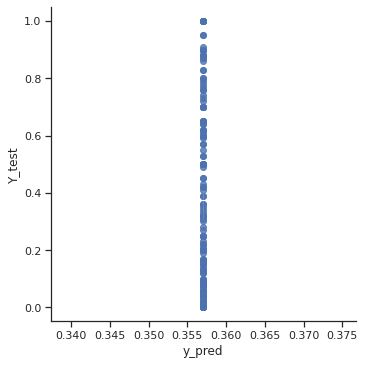

4
Mean Predictor
175
2-fold :  27.42857142857143
3-fold :  57.14285714285714
5-fold :  66.85714285714286
gmfe :  4.538879399319375
mfe :  1.560161098235551
bias :  0.16832339947999997
rmse  0.34664018577886785
r2  0.0


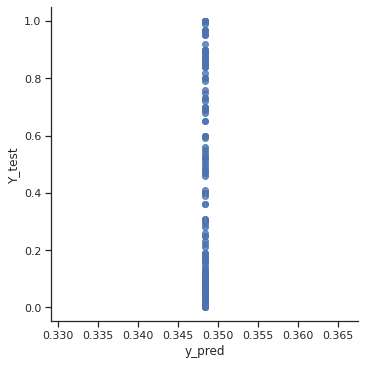

human_mrt
0
Mean Predictor
249
2-fold :  39.3574297188755
3-fold :  55.42168674698795
5-fold :  75.1004016064257
gmfe :  3.0951523612809466
mfe :  1.530937011108236
bias :  0.2191825851140332
rmse  0.6202944790837183
r2  0.0


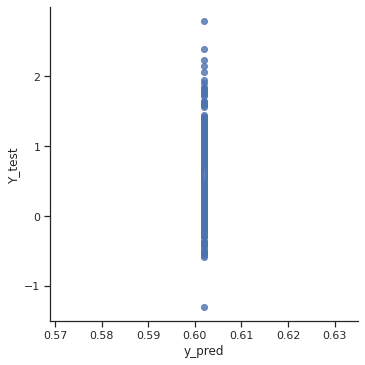

1
Mean Predictor
249
2-fold :  36.144578313253014
3-fold :  60.6425702811245
5-fold :  77.10843373493977
gmfe :  2.9822282808249523
mfe :  1.4798573307029563
bias :  0.7722702961420431
rmse  0.6025604033319867
r2  0.0


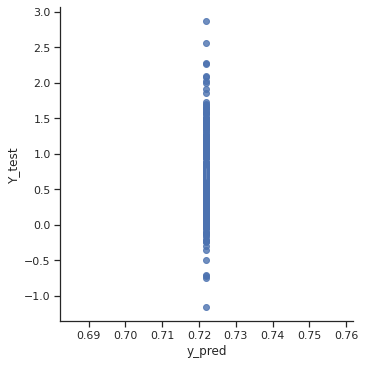

2
Mean Predictor
249
2-fold :  39.3574297188755
3-fold :  56.62650602409639
5-fold :  76.70682730923694
gmfe :  3.274862326398027
mfe :  1.5029338184159038
bias :  0.35481491780069696
rmse  0.6618128658947248
r2  0.0


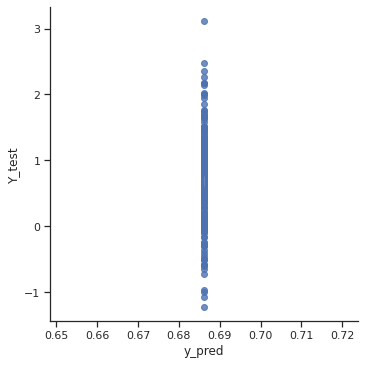

3
Mean Predictor
248
2-fold :  39.11290322580645
3-fold :  55.24193548387096
5-fold :  72.98387096774194
gmfe :  3.3966754745156496
mfe :  1.5256439285079353
bias :  0.40960873066292525
rmse  0.6926469719167251
r2  0.0


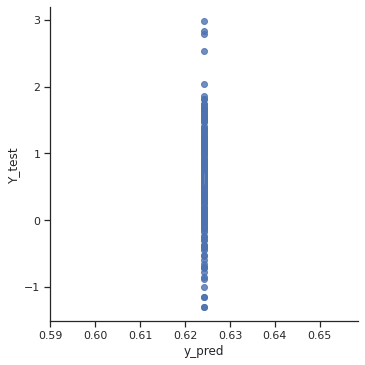

4
Mean Predictor
248
2-fold :  43.54838709677419
3-fold :  61.29032258064516
5-fold :  77.01612903225806
gmfe :  2.964185929697625
mfe :  1.429059985589194
bias :  0.37792331355947706
rmse  0.6164974287048436
r2  0.0


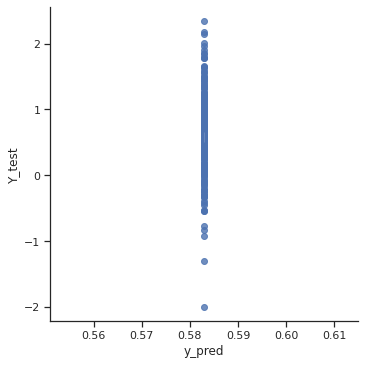

0
Mean Predictor
249
2-fold :  39.3574297188755
3-fold :  59.83935742971887
5-fold :  78.3132530120482
gmfe :  3.0670197928706906
mfe :  1.4418005351430634
bias :  0.312109732196884
rmse  0.6417758119873929
r2  0.0


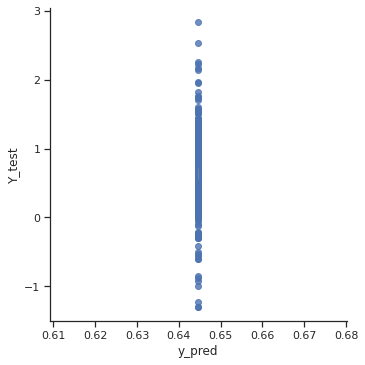

1
Mean Predictor
249
2-fold :  35.34136546184739
3-fold :  55.020080321285135
5-fold :  74.69879518072288
gmfe :  3.435668820421786
mfe :  1.5349272397398086
bias :  0.46694010655170715
rmse  0.6944685754671067
r2  0.0


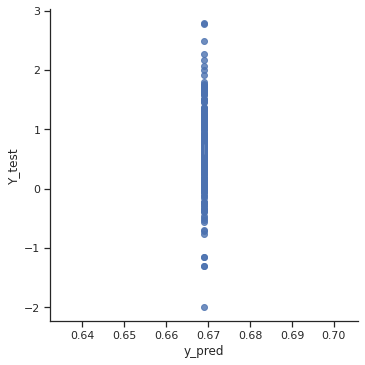

2
Mean Predictor
249
2-fold :  36.144578313253014
3-fold :  55.82329317269076
5-fold :  79.51807228915662
gmfe :  3.0851611891090918
mfe :  1.534482754050167
bias :  0.9770082001139966
rmse  0.6123885633225714
r2  0.0


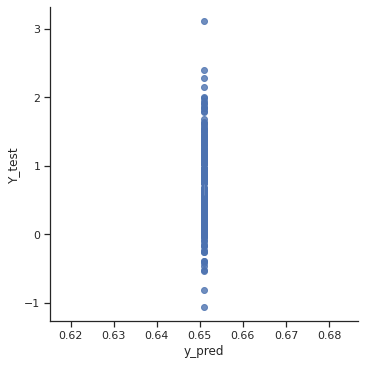

3
Mean Predictor
248
2-fold :  38.306451612903224
3-fold :  54.43548387096774
5-fold :  70.96774193548387
gmfe :  3.253850688029527
mfe :  1.5069779648791621
bias :  0.4718109348955899
rmse  0.6589556735564921
r2  0.0


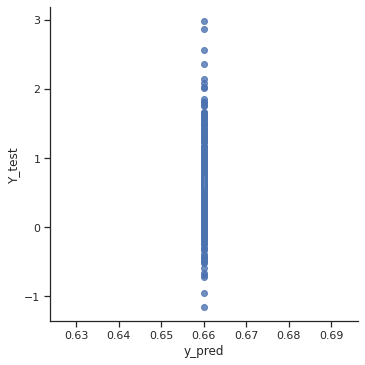

4
Mean Predictor
248
2-fold :  40.32258064516129
3-fold :  60.483870967741936
5-fold :  75.40322580645162
gmfe :  2.9522921983328048
mfe :  1.487183969612386
bias :  0.035391747436023246
rmse  0.5934224187000512
r2  0.0


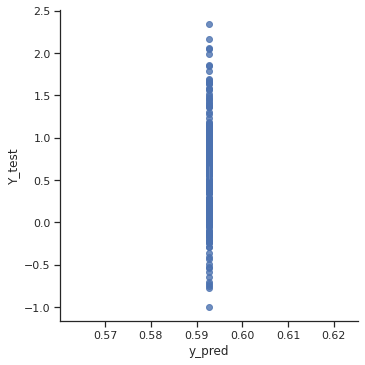

0
Mean Predictor
249
2-fold :  44.57831325301205
3-fold :  63.05220883534136
5-fold :  78.714859437751
gmfe :  2.862198054181225
mfe :  1.4152083801513746
bias :  0.49493291675001405
rmse  0.5932601509797037
r2  0.0


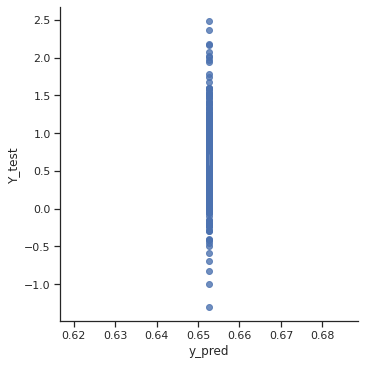

1
Mean Predictor
249
2-fold :  36.144578313253014
3-fold :  51.80722891566265
5-fold :  73.89558232931726
gmfe :  3.3840860469693474
mfe :  1.5848592076043295
bias :  -0.13521076469635673
rmse  0.6923128452649305
r2  0.0


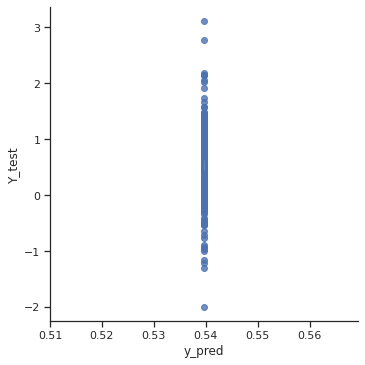

2
Mean Predictor
249
2-fold :  35.7429718875502
3-fold :  53.81526104417671
5-fold :  75.1004016064257
gmfe :  3.1680769639976156
mfe :  1.545188357340266
bias :  0.3301465630866929
rmse  0.6224031228510944
r2  0.0


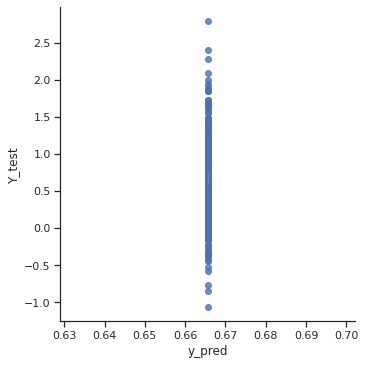

3
Mean Predictor
248
2-fold :  41.12903225806452
3-fold :  62.5
5-fold :  77.41935483870968
gmfe :  3.0353847760453183
mfe :  1.4472133408981918
bias :  0.5962673406909724
rmse  0.6257738957570943
r2  0.0


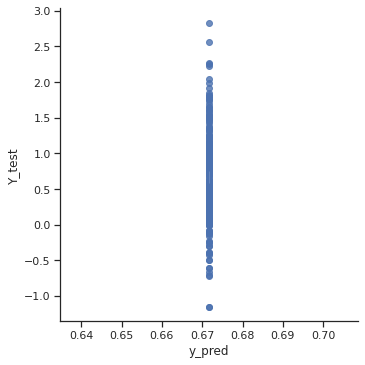

4
Mean Predictor
248
2-fold :  34.274193548387096
3-fold :  52.82258064516129
5-fold :  74.59677419354838
gmfe :  3.3264884516565174
mfe :  1.5417836212297449
bias :  0.7226703624673556
rmse  0.6594622111691154
r2  0.0


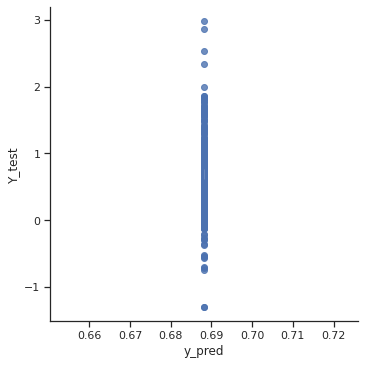

0
Mean Predictor
249
2-fold :  35.34136546184739
3-fold :  56.62650602409639
5-fold :  75.90361445783132
gmfe :  3.1646933934030024
mfe :  1.5254191162780815
bias :  0.22368966831953596
rmse  0.633703233084372
r2  0.0


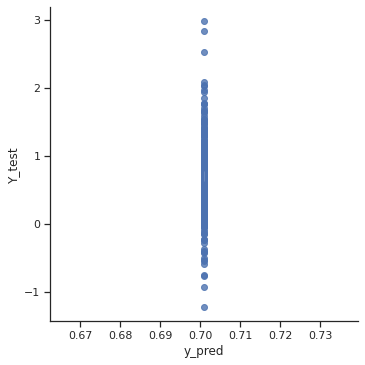

1
Mean Predictor
249
2-fold :  35.7429718875502
3-fold :  54.21686746987952
5-fold :  73.09236947791165
gmfe :  3.454933539634506
mfe :  1.5528606770603546
bias :  0.12643881548446956
rmse  0.6989298094397168
r2  0.0


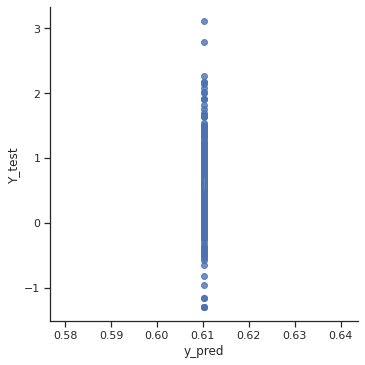

2
Mean Predictor
249
2-fold :  40.562248995983936
3-fold :  63.45381526104418
5-fold :  76.70682730923694
gmfe :  3.014876696150171
mfe :  1.4390841909916376
bias :  0.4866237372342619
rmse  0.6348625966838124
r2  0.0


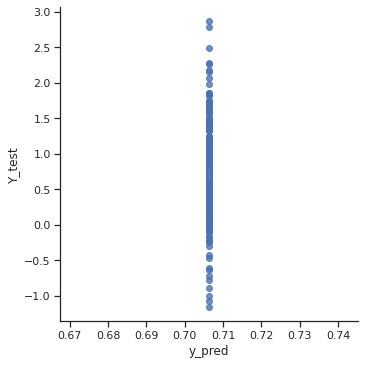

3
Mean Predictor
248
2-fold :  41.12903225806452
3-fold :  58.46774193548387
5-fold :  75.80645161290323
gmfe :  3.024665050332546
mfe :  1.4956836460816938
bias :  0.3351203536719529
rmse  0.6027790294935088
r2  0.0


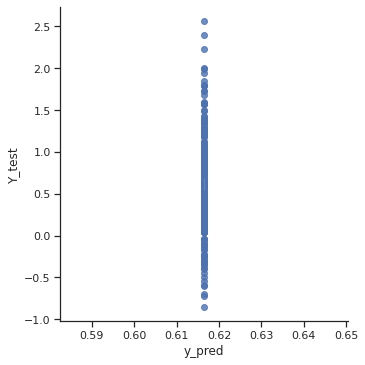

4
Mean Predictor
248
2-fold :  40.725806451612904
3-fold :  58.87096774193549
5-fold :  75.40322580645162
gmfe :  3.035932185565005
mfe :  1.4998127059396713
bias :  0.4290798777281841
rmse  0.624306446834764
r2  0.0


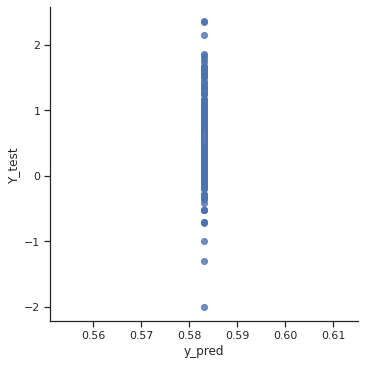

0
Mean Predictor
249
2-fold :  35.7429718875502
3-fold :  55.42168674698795
5-fold :  73.09236947791165
gmfe :  3.3639565381832814
mfe :  1.4985849582456108
bias :  0.7225296075999861
rmse  0.671890038670798
r2  0.0


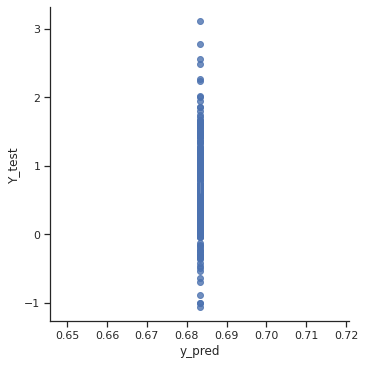

1
Mean Predictor
249
2-fold :  38.95582329317269
3-fold :  56.62650602409639
5-fold :  78.3132530120482
gmfe :  3.093253655204646
mfe :  1.530583204764204
bias :  0.3901721410800847
rmse  0.6234407372686372
r2  0.0


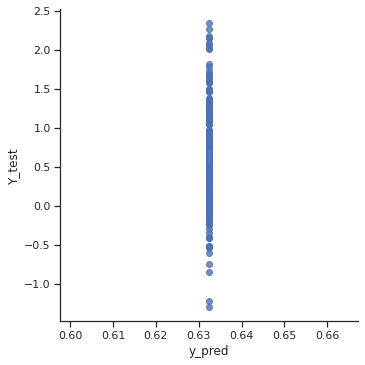

2
Mean Predictor
249
2-fold :  42.168674698795186
3-fold :  57.831325301204814
5-fold :  78.3132530120482
gmfe :  2.9320576785857124
mfe :  1.4561812974004449
bias :  0.07651465440085836
rmse  0.6090598768436248
r2  0.0


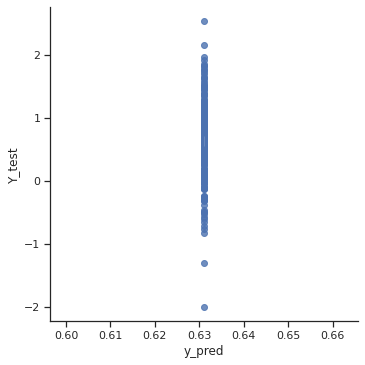

3
Mean Predictor
248
2-fold :  33.46774193548387
3-fold :  56.451612903225815
5-fold :  71.7741935483871
gmfe :  3.4278713552574787
mfe :  1.5138493522661163
bias :  0.7036590064938588
rmse  0.6856378965122504
r2  0.0


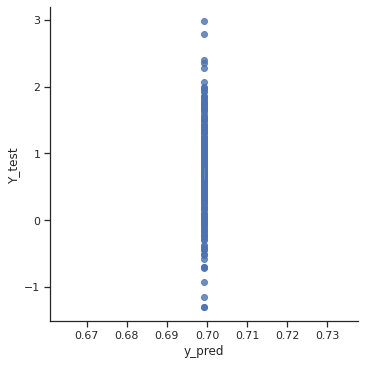

4
Mean Predictor
248
2-fold :  39.11290322580645
3-fold :  59.2741935483871
5-fold :  78.62903225806451
gmfe :  2.958138598417627
mfe :  1.5112045184593916
bias :  0.32798792429573087
rmse  0.6066440966957474
r2  0.0


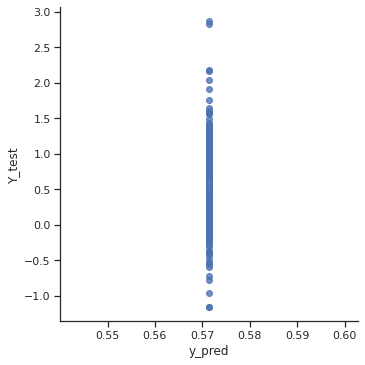

human_thalf
0
Mean Predictor
253
2-fold :  31.225296442687743
3-fold :  50.988142292490124
5-fold :  76.6798418972332
gmfe :  3.235964930515217
mfe :  1.5869988669223982
bias :  -0.17627658454176665
rmse  0.6276496258556437
r2  0.0


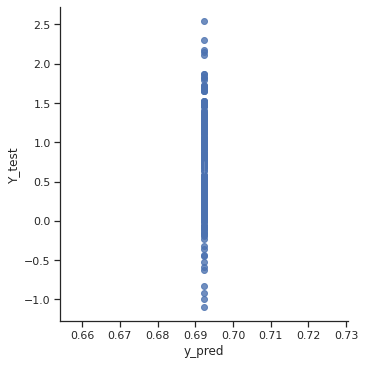

1
Mean Predictor
253
2-fold :  39.130434782608695
3-fold :  57.70750988142292
5-fold :  74.30830039525692
gmfe :  3.052639184619499
mfe :  1.5053379274686711
bias :  0.14120463857549748
rmse  0.6216759075621812
r2  0.0


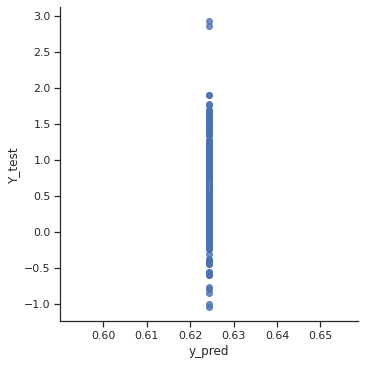

2
Mean Predictor
253
2-fold :  35.177865612648226
3-fold :  62.450592885375485
5-fold :  80.63241106719367
gmfe :  2.9623306844352637
mfe :  1.5131481353187144
bias :  0.8494511821865509
rmse  0.5833961460467985
r2  0.0


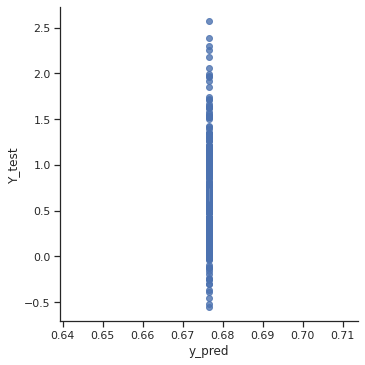

3
Mean Predictor
253
2-fold :  32.41106719367589
3-fold :  56.52173913043478
5-fold :  72.72727272727273
gmfe :  3.4395417265077413
mfe :  1.521608668472012
bias :  0.3647094184394586
rmse  0.6993278028514759
r2  0.0


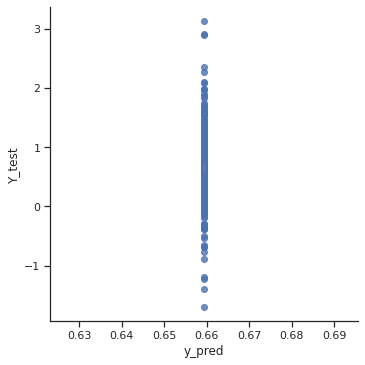

4
Mean Predictor
253
2-fold :  37.54940711462451
3-fold :  62.845849802371546
5-fold :  78.65612648221344
gmfe :  2.8284727186669447
mfe :  1.4537511380019095
bias :  0.14011574048219178
rmse  0.5724877625130869
r2  0.0


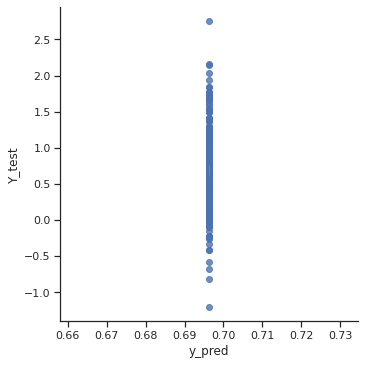

0
Mean Predictor
253
2-fold :  38.3399209486166
3-fold :  58.498023715415016
5-fold :  79.05138339920948
gmfe :  2.85727415245504
mfe :  1.4848704254892124
bias :  0.08992677143146288
rmse  0.5640160947252242
r2  0.0


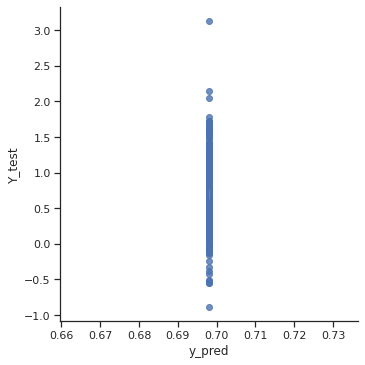

1
Mean Predictor
253
2-fold :  32.80632411067194
3-fold :  62.055335968379445
5-fold :  75.09881422924902
gmfe :  3.2775383149311286
mfe :  1.4877765107435397
bias :  0.5066641704761863
rmse  0.6669543732450867
r2  0.0


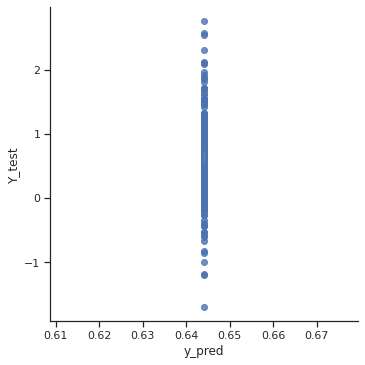

2
Mean Predictor
253
2-fold :  37.15415019762846
3-fold :  57.31225296442688
5-fold :  78.26086956521739
gmfe :  2.99464054381311
mfe :  1.5037741854018993
bias :  0.061067733524739154
rmse  0.607582535282422
r2  0.0


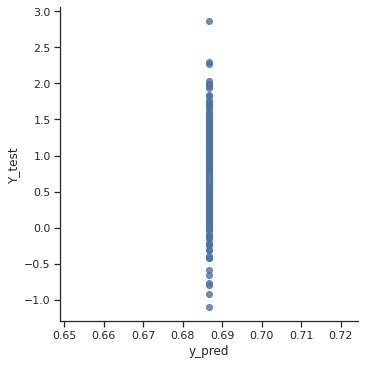

3
Mean Predictor
253
2-fold :  30.8300395256917
3-fold :  54.1501976284585
5-fold :  75.09881422924902
gmfe :  3.176906892625672
mfe :  1.5652578357875662
bias :  -0.014380344013519064
rmse  0.6190731476665386
r2  0.0


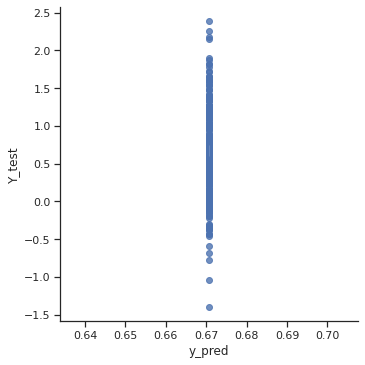

4
Mean Predictor
253
2-fold :  36.36363636363637
3-fold :  59.28853754940712
5-fold :  76.6798418972332
gmfe :  3.2055244508570784
mfe :  1.4831196255994858
bias :  0.8608768050726003
rmse  0.6507617305416402
r2  0.0


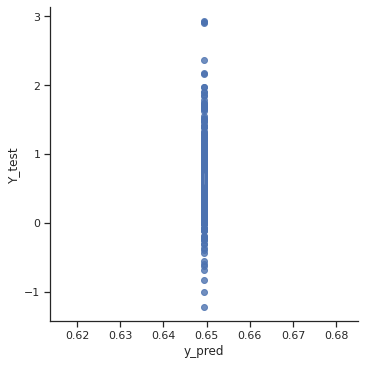

0
Mean Predictor
253
2-fold :  37.54940711462451
3-fold :  62.845849802371546
5-fold :  79.05138339920948
gmfe :  2.8095005373055697
mfe :  1.4555222982385208
bias :  0.4720596611767345
rmse  0.5688652101934591
r2  0.0


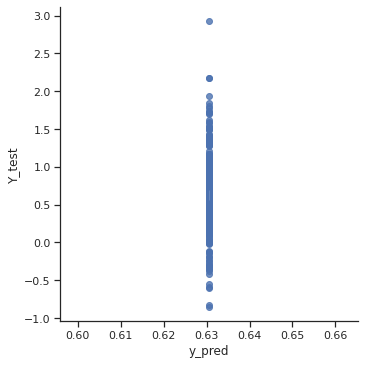

1
Mean Predictor
253
2-fold :  28.458498023715418
3-fold :  53.75494071146245
5-fold :  74.70355731225297
gmfe :  3.3152541755552116
mfe :  1.53898158731689
bias :  0.18743382097941375
rmse  0.648529799802652
r2  0.0


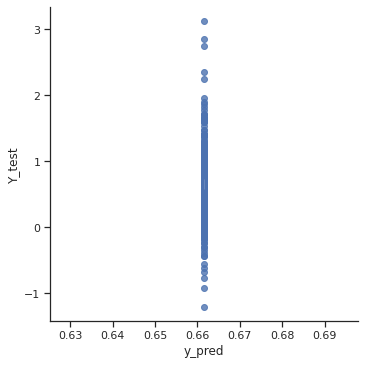

2
Mean Predictor
253
2-fold :  32.015810276679844
3-fold :  62.055335968379445
5-fold :  77.86561264822134
gmfe :  2.9808550168556933
mfe :  1.4690071854208526
bias :  -0.16261222490431138
rmse  0.599659787384114
r2  0.0


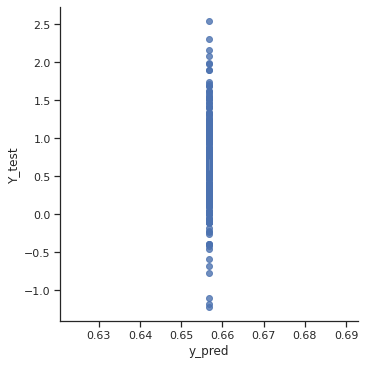

3
Mean Predictor
253
2-fold :  32.015810276679844
3-fold :  55.33596837944664
5-fold :  73.12252964426878
gmfe :  3.3495210988358814
mfe :  1.5481309168395896
bias :  0.6240317920794514
rmse  0.6600359414405672
r2  0.0


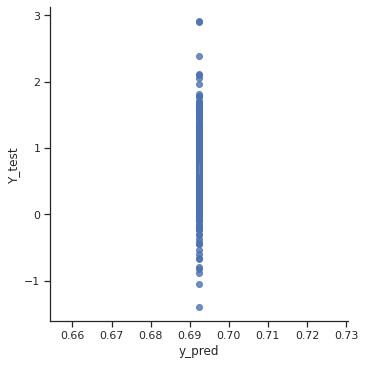

4
Mean Predictor
253
2-fold :  39.52569169960474
3-fold :  56.52173913043478
5-fold :  75.49407114624506
gmfe :  3.0839490131479876
mfe :  1.5219424788309082
bias :  0.30257263388666544
rmse  0.630750513977834
r2  0.0


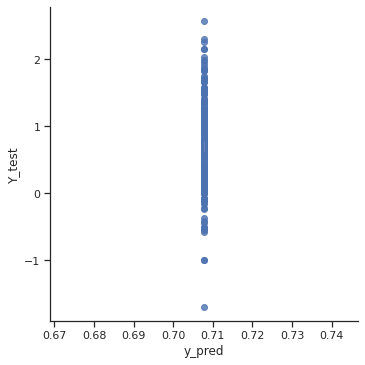

0
Mean Predictor
253
2-fold :  34.78260869565217
3-fold :  58.10276679841897
5-fold :  77.86561264822134
gmfe :  3.0976361831141355
mfe :  1.5240445522279147
bias :  0.44792773692501875
rmse  0.6250839289813729
r2  0.0


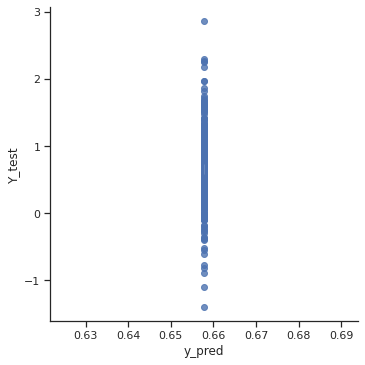

1
Mean Predictor
253
2-fold :  35.177865612648226
3-fold :  60.47430830039525
5-fold :  79.84189723320159
gmfe :  2.86427984962447
mfe :  1.4541963899245272
bias :  0.3645029861782154
rmse  0.570831212765015
r2  0.0


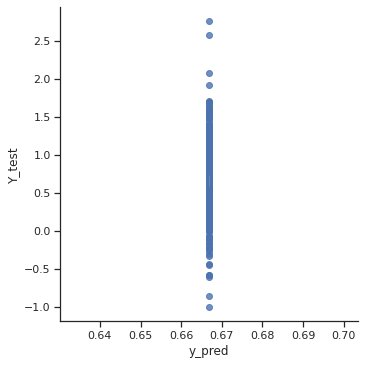

2
Mean Predictor
253
2-fold :  35.96837944664031
3-fold :  60.86956521739131
5-fold :  77.86561264822134
gmfe :  3.097848646880354
mfe :  1.4954505998787415
bias :  0.2949003748341026
rmse  0.6433455160675775
r2  0.0


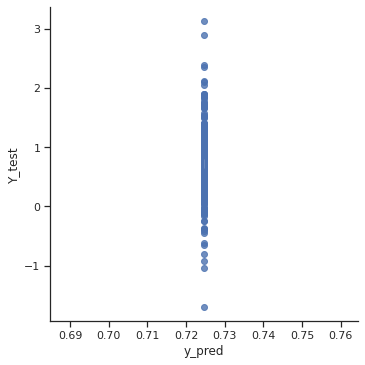

3
Mean Predictor
253
2-fold :  30.8300395256917
3-fold :  54.9407114624506
5-fold :  73.12252964426878
gmfe :  3.3480962703756747
mfe :  1.5429788402407472
bias :  0.2467748679790347
rmse  0.6482624269092572
r2  0.0


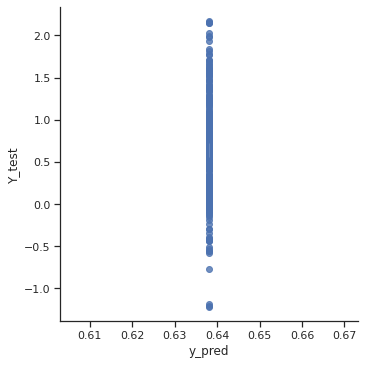

4
Mean Predictor
253
2-fold :  35.177865612648226
3-fold :  56.52173913043478
5-fold :  76.28458498023716
gmfe :  3.1035401031568255
mfe :  1.5011828663967173
bias :  0.3869697919848969
rmse  0.6213343898369841
r2  0.0


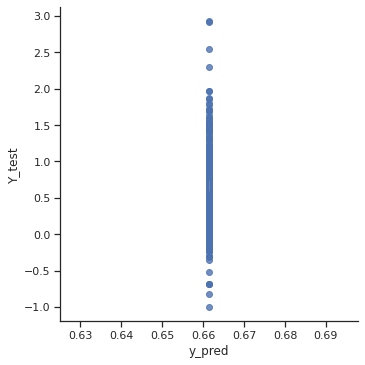

0
Mean Predictor
253
2-fold :  33.99209486166008
3-fold :  58.10276679841897
5-fold :  77.07509881422925
gmfe :  3.0641124084349354
mfe :  1.5285351260666233
bias :  0.2818743828433412
rmse  0.6172034133121079
r2  0.0


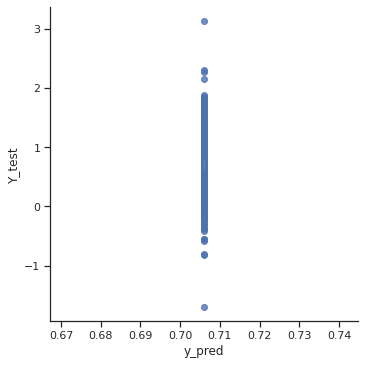

1
Mean Predictor
253
2-fold :  40.316205533596836
3-fold :  62.055335968379445
5-fold :  78.65612648221344
gmfe :  2.834500235478095
mfe :  1.4609524978183792
bias :  0.44822791865471423
rmse  0.5673953200923643
r2  0.0


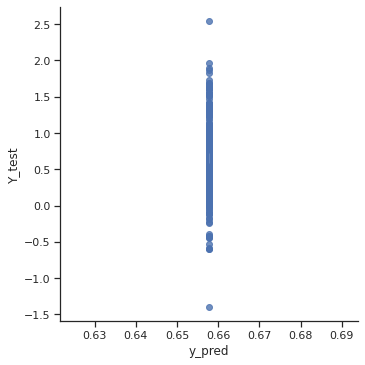

2
Mean Predictor
253
2-fold :  34.78260869565217
3-fold :  61.26482213438735
5-fold :  79.44664031620553
gmfe :  2.9775009527702125
mfe :  1.4579607941183435
bias :  -0.043063067531442734
rmse  0.6059169290287886
r2  0.0


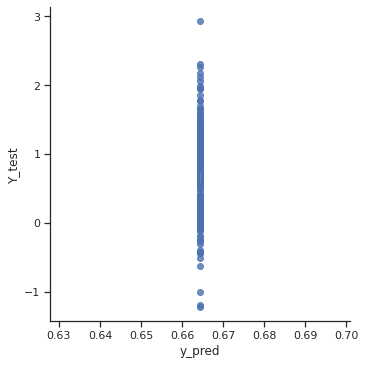

3
Mean Predictor
253
2-fold :  28.458498023715418
3-fold :  52.569169960474305
5-fold :  72.33201581027669
gmfe :  3.499386514766234
mfe :  1.576415878381877
bias :  0.706870732994358
rmse  0.6816235231226337
r2  0.0


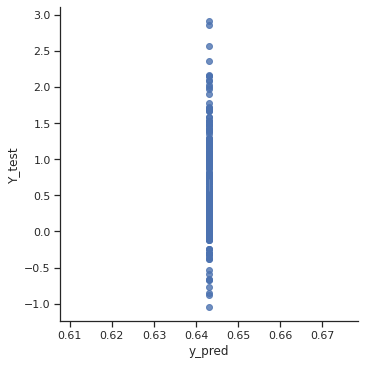

4
Mean Predictor
253
2-fold :  34.387351778656125
3-fold :  59.683794466403164
5-fold :  74.30830039525692
gmfe :  3.158331962047474
mfe :  1.4903420771617992
bias :  0.06166980843149883
rmse  0.6357063209731337
r2  0.0


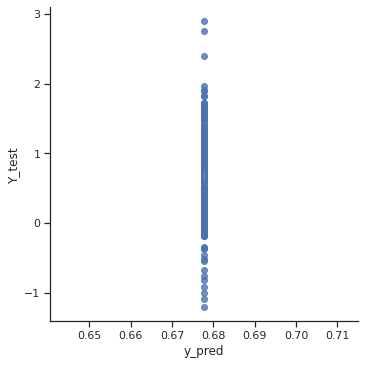

In [8]:
import pickle
list_of_lists=[]
detail_list_batch=[]
model_parameters_batch=[]


for endpoint in ["human_VDss_L_kg","human_CL_mL_min_kg", "human_fup", "human_mrt", "human_thalf"]:

    data = human_lombardo
    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)
    
    Y = df[endpoint]
    
    #Nested Cross Validation    
    for i in range(42, 47):
        
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(Y)):
            
            print(split)
            train = df.iloc[train_index]
            Y_train= Y.iloc[train_index].values.flatten()
            test = df.iloc[test_index]
            Y_test= Y.iloc[test_index].values.flatten()


            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model

            print("Mean Predictor")  
            y_pred =  np.full((len(Y_test), ), Y_test.mean()) 
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            sns.set_theme(style="ticks")
            df_plot=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df_plot, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)
            
            #combine results
            for smiles_r, pred, true in zip(test.smiles_r, y_pred, Y_test):
                detail_list_batch.append([endpoint, i, split, smiles_r, pred, true])


In [9]:
detail_list = pd.DataFrame(detail_list_batch,columns=["endpoint", "random_state", 
                                                           "split", "smiles_r", "pred", "true"])
detail_list["key"] =  detail_list["endpoint"].astype(str) + detail_list["smiles_r"].astype(str) + detail_list["random_state"].astype(str)+ detail_list["split"].astype(str)
detail_list

,endpoint,random_state,split,smiles_r,pred,true,key
0,human_VDss_L_kg,42,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,0.048337,0.633468,human_VDss_L_kgC#C[C@]1(O)CC[C@H]2[C@@H]3CCc4c...
1,human_VDss_L_kg,42,0,C=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N)nc(N)c3n2)cc1)...,0.048337,-0.154902,human_VDss_L_kgC=C(CC(NC(=O)c1ccc(CCc2cnc3nc(N...
2,human_VDss_L_kg,42,0,C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=...,0.048337,-0.619789,human_VDss_L_kgC=CC1=C(C(=O)[O-])[NH+]2C(=O)C(...
3,human_VDss_L_kg,42,0,C=CCc1ccccc1OCC(O)C[NH2+]C(C)C,0.048337,0.505150,human_VDss_L_kgC=CCc1ccccc1OCC(O)C[NH2+]C(C)C420
4,human_VDss_L_kg,42,0,C=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H](Oc2ncc(OC)c3c...,0.048337,0.442480,human_VDss_L_kgC=C[C@@H]1C[C@]1(NC(=O)C1C[C@@H...
...,...,...,...,...,...,...,...
29580,human_thalf,46,4,[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-])c(Br)c1)NC...,0.677759,0.397940,human_thalf[NH3+]CCCCC(NC(=O)C(Cc1cc(Br)c([O-]...
29581,human_thalf,46,4,[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21,0.677759,1.064458,human_thalf[NH3+]C[C@H]1OB(O)c2c(OCCCO)cccc21464
29582,human_thalf,46,4,[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1,0.677759,-0.173925,human_thalf[O-]c1ccc(C2=Cc3ccc([O-])cc3OC2)cc1464
29583,human_thalf,46,4,[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-])c([O-])c3...,0.677759,0.000000,human_thalf[O-]c1ccc([C@H]2C[NH2+]CCc3c2cc([O-...


In [10]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

,HeldOut,endpoint,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
0,HeldOut,human_VDss_L_kg,42,0,40.000000,48.400000,67.200000,3.336014,1.666229,0.117729,0.656861,0.0
1,HeldOut,human_VDss_L_kg,42,1,36.000000,52.400000,74.800000,3.176437,1.560619,0.064162,0.611018,0.0
2,HeldOut,human_VDss_L_kg,42,2,34.000000,49.600000,68.800000,3.387114,1.655843,0.146752,0.659072,0.0
3,HeldOut,human_VDss_L_kg,42,3,36.400000,52.000000,67.600000,3.315049,1.587130,0.075410,0.647149,0.0
4,HeldOut,human_VDss_L_kg,42,4,35.742972,50.602410,71.485944,3.241827,1.595411,0.117378,0.621148,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
120,HeldOut,human_thalf,46,0,33.992095,58.102767,77.075099,3.064112,1.528535,0.281874,0.617203,0.0
121,HeldOut,human_thalf,46,1,40.316206,62.055336,78.656126,2.834500,1.460952,0.448228,0.567395,0.0
122,HeldOut,human_thalf,46,2,34.782609,61.264822,79.446640,2.977501,1.457961,-0.043063,0.605917,0.0
123,HeldOut,human_thalf,46,3,28.458498,52.569170,72.332016,3.499387,1.576416,0.706871,0.681624,0.0


In [11]:
detail_list.to_csv("detail_list_Prediction_human_mean_predictor.csv", index=False)

In [12]:
results.to_csv("Prediction_human_mean_predictor.csv", index=False)

In [13]:
import pandas as pd
results= pd.read_csv("Prediction_human_mean_predictor.csv")
results.groupby("endpoint").mean().reset_index().to_csv("human_from_mean_predictor.csv", index=False)
results.groupby("endpoint").mean()

,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
endpoint,,,,,,,,,,
human_CL_mL_min_kg,44.0,2.0,36.173760,59.187804,77.767935,3.154894,1.493044,-0.611994,0.646613,0.0
human_VDss_L_kg,44.0,2.0,36.380594,50.888610,70.538153,3.289723,1.598284,0.093560,0.639004,0.0
human_fup,44.0,2.0,30.170000,59.317403,68.735714,4.466619,1.529740,0.139569,0.339701,0.0
human_mrt,44.0,2.0,38.472471,57.442544,75.783133,3.150148,1.501253,0.409107,0.639172,0.0
human_thalf,44.0,2.0,34.577075,58.276680,76.569170,3.104606,1.506851,0.297740,0.621499,0.0
